# Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib # модуль для сохранения и открытия моделей
import sklearn
import os
import time

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# Подготовка данных

## Загрузка обучающего и тестового датасетов

In [2]:
df_train = pd.read_csv('news_train.csv')
df_test = pd.read_csv('news_test.csv')

X_train, y_train = df_train['text_lemma'], df_train.drop('text_lemma', axis=1)
X_test, y_test = df_test['text_lemma'], df_test.drop('text_lemma', axis=1)

## Метрики

In [3]:
def identity(y_test, y_pred):
    '''
    Расчёт похожести объектов через расстояние Хэмминга

    y_test - тестовые целевые данные

    y_pred - предсказанные целевые данные

    Вывод среднего значения похожести объектов по всем элементам 

    '''
    y_true = y_test.to_numpy()

    if (len(y_true) != len(y_pred)):

        raise Exception('Объекты должны быть одинаковой длины')
    identity_list = []
    for elem in range(len(y_true)):
        #print('true:', y_true[elem])
        #print('pred:', y_pred[elem])
        #print(len(y_true[elem]) == len(y_pred[elem]))
        #print(len(y_test[elem]))
        if (len(y_true[elem]) != len(y_pred[elem])):

            raise Exception('Элементы должны быть одинаковой длины')
        # Инициализация переменной расстояния Хэмминга
        dist_counter = 0
        for n in range(len(y_true[elem])):
            # Изменение расстояния Хэмминга при наличии разницы между объектами
            if y_true[elem][n] != y_pred[elem][n]:
                
                dist_counter += 1
                
        len_elem = len(y_true[elem])
        # Расчёт доли похожести элементов двух объектов через Расстояние Хэмминга(dist_counter/len_elem - доля непохожести двух объектов)
        identity = round(1 - dist_counter/len_elem, 3)
        identity_list.append(identity)

    return round(np.mean(identity_list),5)

In [4]:
def hamming_distance(y_test, y_pred):
    '''
    Расчёт доработанного расстояния Хэмминга с ориентацией на целевое значение = 1

    y_test - тестовые целевые данные

    y_pred - предсказанные целевые данные

    Вывод среднего значения расстояния Хэмминга по всем элементам 

    '''
    y_true = y_test.to_numpy()

    if (len(y_true) != len(y_pred)):
        raise Exception('Объекты должны быть одинаковой длины')
    distance_list = []
    
    for elem in range(len(y_true)):
        if (len(y_true[elem]) != len(y_pred[elem])):
            raise Exception('Элементы должны быть одинаковой длины')

        indices_1_y_true = set(np.where(y_true[elem])[0])
        indices_1_y_pred = set(np.where(y_pred[elem])[0])
        
        if len(indices_1_y_true) == 0 and len(indices_1_y_pred) == 0:
            dist_counter = 1

        else:
            dist_counter = len(indices_1_y_true.intersection(indices_1_y_pred)) / float(len(indices_1_y_true.union(indices_1_y_pred)))

        distance_list.append(dist_counter)
    return round(np.mean(distance_list),5)

In [5]:
def estimation(y_test, y_pred, save_file=False, filename='filename'):
    '''
    Вывод результирующих метрик
    '''
    
    columns = y_test.columns
    y_true = y_test.to_numpy()
    print('Accuracy:', round(accuracy_score(y_true, y_pred), 5))
    print('Hamming distance:', hamming_distance(y_test, y_pred))
    print('Identity (by Hamming distance):', identity(y_test, y_pred), '\n')
    print(classification_report(y_true, y_pred, target_names=columns, zero_division=0))
    
    if save_file is True:
        np.savetxt(filename, y_pred.astype(int), fmt='%i', delimiter=',')

In [6]:
def cm_show(y_test, y_pred, nrows=10, ncols=5, figsize_w=30, figsize_h=60, wspace=0.2, hspace=0.4):
    '''
    Вывод матрицы несоответствия для каждой тематической категории в формате:   
    
    [['TN', 'FP'],
     ['FN', 'TP']]

    y_test - тестовые целевые данные

    y_pred - предсказанные целевые данные

    nrows - количество строк в сетке матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: nrows = figsize_h / 6)

    ncols - количество столбцов в сетке матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: ncols = figsize_w / 6)

    figsize_w - ширина полотна для вывода сетки матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: figsize_h = 6 * ncols)

    figsize_h - высота полотна для вывода сетки матриц несоответствия (для корректного отображения сетки должно
    работать уравнение: figsize_h = 6 * nrows)

    wspace - расстояние по ширине между отдельными ячейками сетки матриц несоответствия

    hspace - расстояние по высоте между отдельными ячейками сетки матриц несоответствия
    '''
    
    start = time.time()
    y_true = y_test.to_numpy()
    axis = plt.subplots(nrows, ncols, figsize=(figsize_w, figsize_h))[1]
    axis = axis.ravel()
    
    # обычная матрица несоответствий
    # actual = np.array(y_true).T
    # predicted = np.array(y_pred).T
    
    # for tag_num in range(len(y_test.columns)):
    #    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(actual[tag_num], predicted[tag_num]),
    #                                        display_labels = [0,1])
    #    cm_display.plot(ax=axis[tag_num],cmap=plt.cm.GnBu)
    #    cm_display.ax_.set_title(f'{y_test.columns[tag_num]}')
    
    # многоклассовая матрица несоответствий
    mlcm = multilabel_confusion_matrix(y_true, y_pred)
        
    for tag_num in range(len(y_test.columns)):
    #    Если надо отобразить количество
    #    mlcm_display = ConfusionMatrixDisplay(confusion_matrix = mlcm[i], display_labels = [0,1]) 
    #    mlcm_display.plot(ax=axis[tag_num],cmap=plt.cm.GnBu)
    #    mlcm_display.ax_.set_title(f'{y_test.columns[tag_num]}') 

    #   Если надо отобразить проценты. 
    #   Так как в рамках задачи наибольший интерес вызывает информация о точном предсказании (y_true = 1, y_pred = 1)
    #   или о грубой ошибке при предсказании (y_true = 1, y_pred = 0) категории, имеет смысл выводить информацию для
    #   дальнейшего анализа в виде доли верных и неверных предсказаний для целевого значения = 1. 
        mlcm_percent = mlcm[tag_num] / mlcm[tag_num].sum(axis=1).reshape(2, -1)
        
        true0_row = mlcm[tag_num].sum(axis=1)[0] # количество TN, FP предсказаний (нецелевое значение = 0)
        true1_row = mlcm[tag_num].sum(axis=1)[1] # количество TP, FN предсказаний (целевое значение = 1)
        
        mlcm_percent_display = ConfusionMatrixDisplay(mlcm_percent, display_labels=[0, 1])        
        mlcm_percent_display.plot(ax=axis[tag_num],cmap=plt.cm.GnBu, values_format="0.3f")
        mlcm_percent_display.ax_.set_title(f'{y_test.columns[tag_num]} (TL0: {true0_row}, TL1:{true1_row})') 

    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
    return print(f'Время выполнения: {round(time.time() - start,3)} с')

# Модель на униграммах

## Структура

In [7]:
%%time
pipe = Pipeline([('tfidf', TfidfVectorizer(analyzer='word',ngram_range=(1, 1))),
    ('logreg', MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000,class_weight='balanced', multi_class='multinomial',))),])
pipe.fit(X_train, y_train)

CPU times: total: 19min 55s
Wall time: 2min 40s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logreg',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    multi_class='multinomial')))])

## Результаты

### Результаты текущей обученной модели

#### Предсказание, оценка и сохранение результатов

In [8]:
y_pred = pipe.predict(X_test)
estimation(y_test, y_pred, save_file=True, filename='D:\\netology_diplom\\final\\csv_files\\tfidf_logreg_ngram_1_1.csv')
#joblib.dump(pipe, 'D:\\netology_diplom\\final\\models_files\\model_tfidf_logreg_ngram_1_1.pkl')

Accuracy: 0.36987
Hamming distance: 0.58684
Identity (by Hamming distance): 0.98894 

                      precision    recall  f1-score   support

             Coцсети       0.60      0.88      0.71       200
                Авто       0.64      1.00      0.78        28
          Автобизнес       0.41      0.97      0.57        62
          Белоруссия       0.75      0.92      0.82       183
              Бизнес       0.40      0.81      0.54       200
          Бокс и ММА       0.97      0.97      0.97       200
         Бывший СССР       0.57      0.88      0.69       200
                Вещи       0.33      0.51      0.40        85
     Вирусные ролики       0.50      0.89      0.64        95
               Вкусы       0.18      0.45      0.26        11
         Внешний вид       0.69      0.94      0.79       145
             Гаджеты       0.49      0.89      0.63       200
               Город       0.35      0.81      0.49       200
        Госэкономика       0.40      0.90    

#### Матрицы несоответствий по категориям

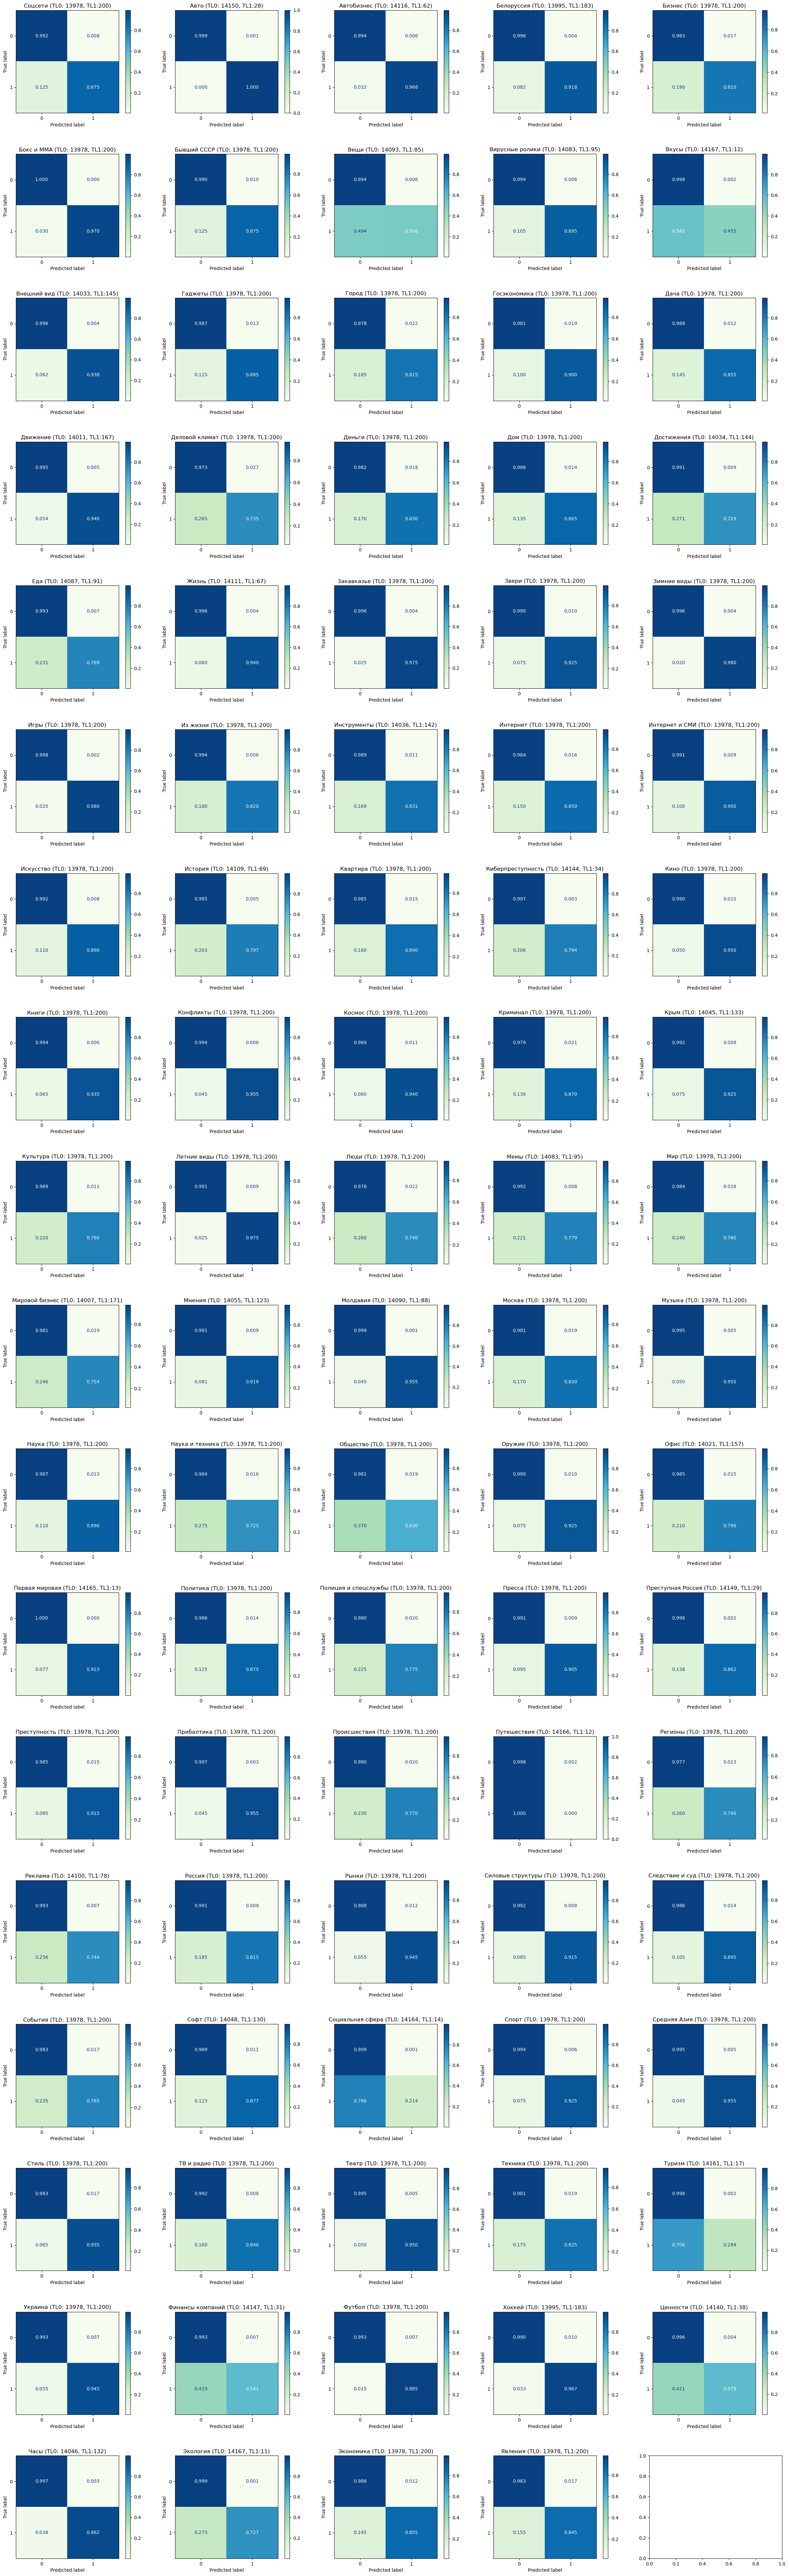

Время выполнения: 7.115 с


In [10]:
cm_show(y_test, 
        y_pred, 
        nrows=18, 
        ncols=5, 
        figsize_w=30, 
        figsize_h=100, 
        wspace=0.2, 
        hspace=0.4
        )

### Результаты ранее обученной модели

#### Загрузка модели, предсказание и оценка

In [11]:
model_path = 'D:\\netology_diplom\\final\\models_files\\model_tfidf_logreg_ngram_1_1.pkl'

model = joblib.load(model_path)
y_pred = model.predict(X_test)
metrics = estimation(y_test, y_pred)

Accuracy: 0.36987
Hamming distance: 0.58684
Identity (by Hamming distance): 0.98894 

                      precision    recall  f1-score   support

             Coцсети       0.60      0.88      0.71       200
                Авто       0.64      1.00      0.78        28
          Автобизнес       0.41      0.97      0.57        62
          Белоруссия       0.75      0.92      0.82       183
              Бизнес       0.40      0.81      0.54       200
          Бокс и ММА       0.97      0.97      0.97       200
         Бывший СССР       0.57      0.88      0.69       200
                Вещи       0.33      0.51      0.40        85
     Вирусные ролики       0.50      0.89      0.64        95
               Вкусы       0.18      0.45      0.26        11
         Внешний вид       0.69      0.94      0.79       145
             Гаджеты       0.49      0.89      0.63       200
               Город       0.35      0.81      0.49       200
        Госэкономика       0.40      0.90    

#### Матрицы несоответствий по категориям

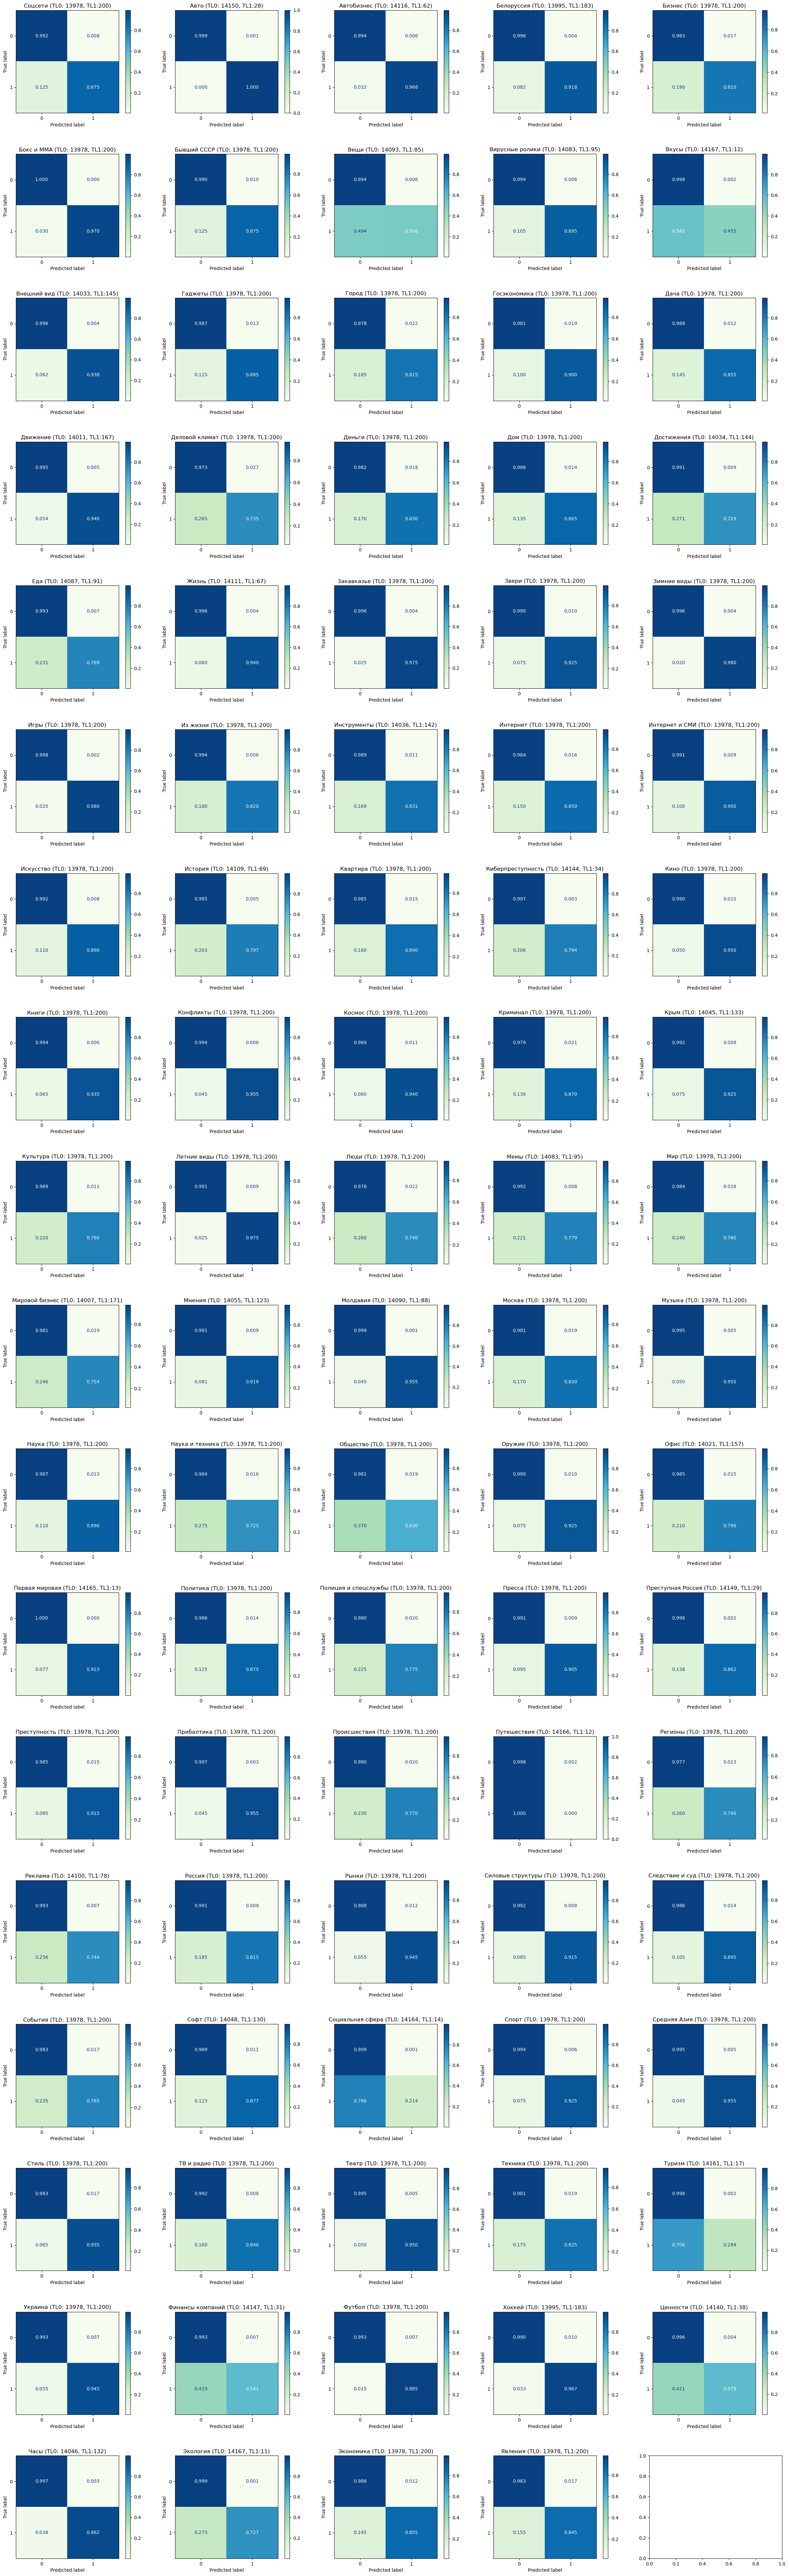

Время выполнения: 7.264 с


In [12]:
cm_show(y_test, 
        y_pred, 
        nrows=18, 
        ncols=5, 
        figsize_w=30, 
        figsize_h=100, 
        wspace=0.2, 
        hspace=0.4
        )

# Модель на униграммах + биграммах

## Структура

In [ ]:
%%time
pipe = Pipeline([('tfidf', TfidfVectorizer(analyzer='word',ngram_range=(1, 2))),
    ('logreg', MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000,class_weight='balanced',multi_class='multinomial',))),])
pipe.fit(X_train, y_train)

CPU times: total: 2h 35min 12s
Wall time: 30min 41s


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('logreg',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    multi_class='multinomial')))])

## Результаты

### Результаты текущей обученной модели

#### Предсказание, оценка и сохранение результатов

In [ ]:
y_pred = pipe.predict(X_test)
estimation(y_test, y_pred, save_file=True, filename='D:\\netology_diplom\\final\\csv_files\\tfidf_logreg_ngram_1_2.csv')
joblib.dump(pipe, 'D:\\netology_diplom\\final\\models_files\\model_tfidf_logreg_ngram_1_2.pkl')

Accuracy: 0.36754
Hamming distance: 0.58182
Identity (by Hamming distance): 0.98904 

                      precision    recall  f1-score   support

             Coцсети       0.55      0.88      0.68       200
                Авто       0.73      0.96      0.83        28
          Автобизнес       0.47      0.95      0.63        62
          Белоруссия       0.73      0.93      0.82       183
              Бизнес       0.43      0.80      0.56       200
          Бокс и ММА       0.97      0.97      0.97       200
         Бывший СССР       0.61      0.86      0.71       200
                Вещи       0.37      0.44      0.40        85
     Вирусные ролики       0.48      0.92      0.63        95
               Вкусы       0.22      0.36      0.28        11
         Внешний вид       0.65      0.94      0.77       145
             Гаджеты       0.48      0.89      0.62       200
               Город       0.35      0.81      0.49       200
        Госэкономика       0.43      0.88    

['D:\\netology_diplom\\final\\models_files\\model_tfidf_logreg_ngram_1_2.pkl']

#### Матрицы несоответствий по категориям

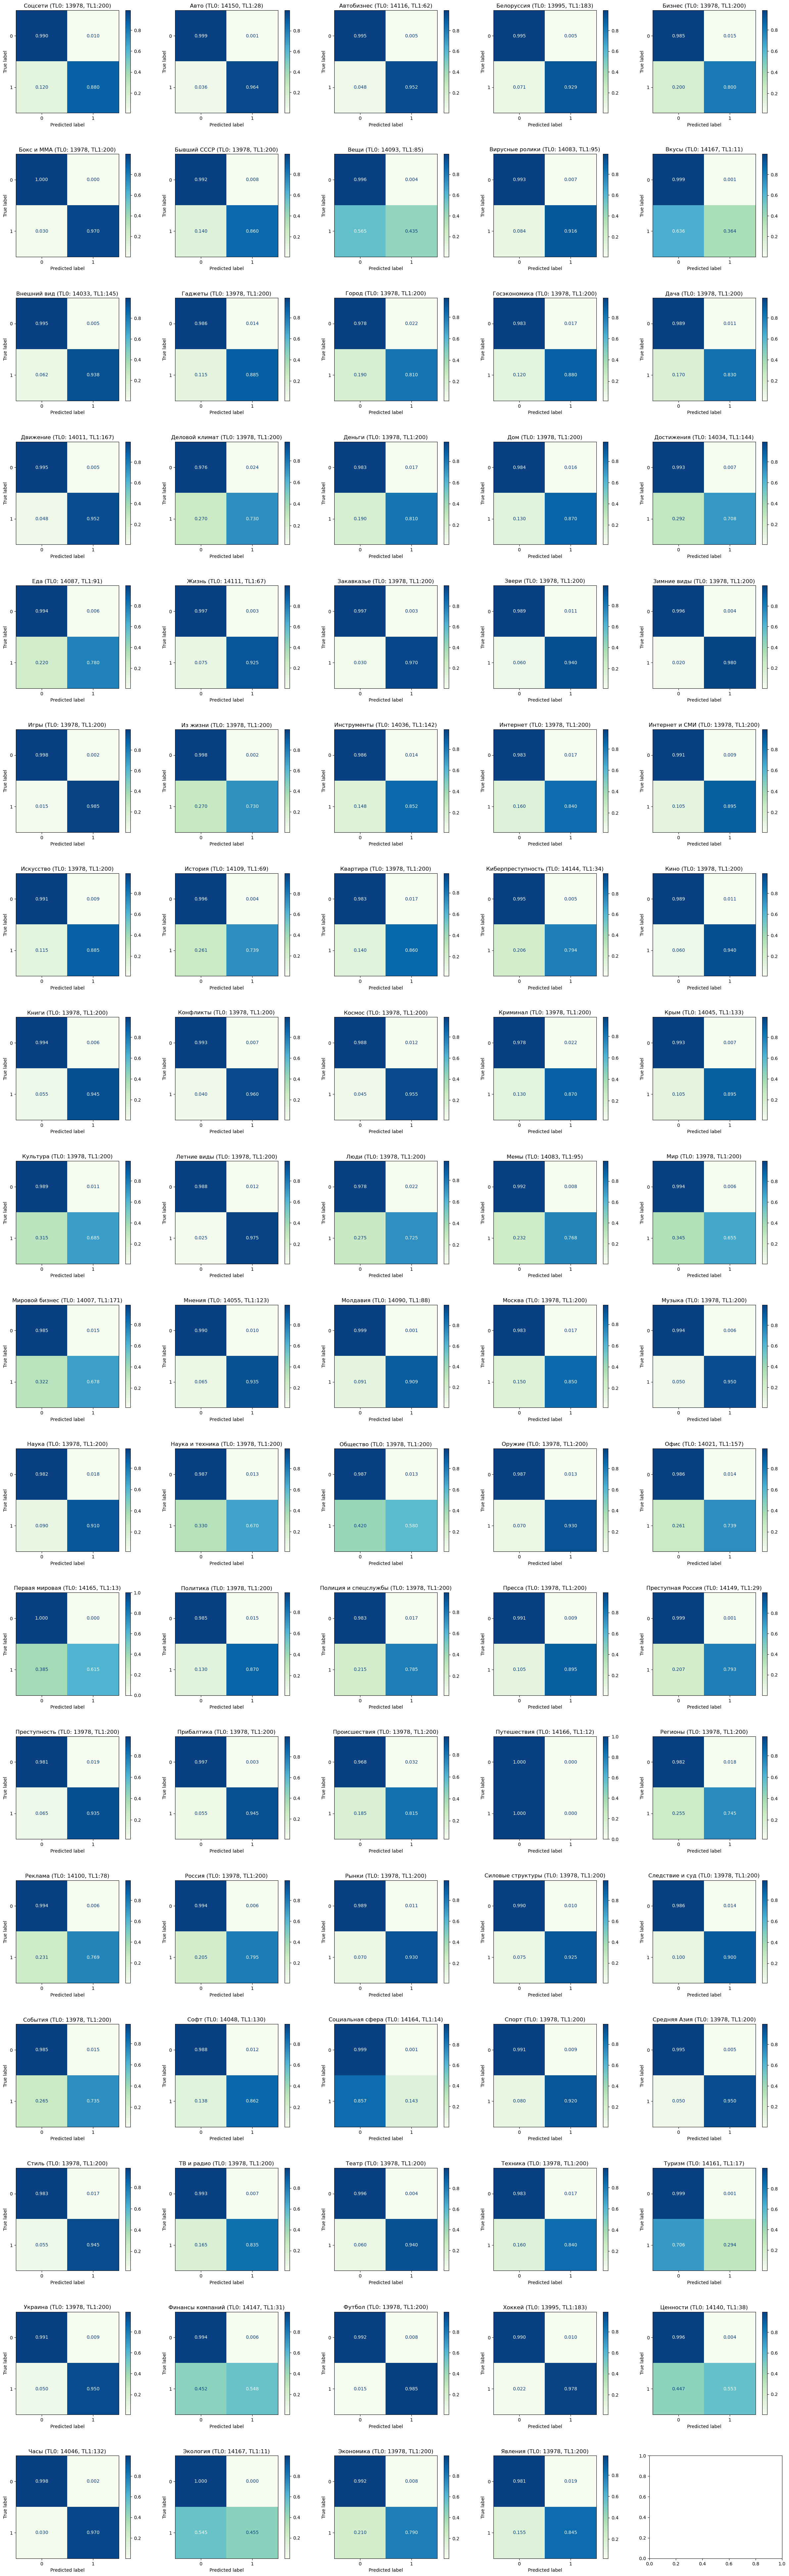

Время выполнения: 7.492 с


In [411]:
cm_show(y_test, 
        y_pred, 
        nrows=18, 
        ncols=5, 
        figsize_w=30, 
        figsize_h=100, 
        wspace=0.2, 
        hspace=0.4
        )

### Результаты ранее обученной модели

#### Загрузка модели, предсказание и оценка

In [412]:
model_path = 'D:\\netology_diplom\\final\\models_files\\model_tfidf_logreg_ngram_1_2.pkl'

model = joblib.load(model_path)
y_pred = model.predict(X_test)
metrics = estimation(y_test, y_pred)

Accuracy: 0.36754
Hamming distance: 0.58182
Identity (by Hamming distance): 0.98904 

                      precision    recall  f1-score   support

             Coцсети       0.55      0.88      0.68       200
                Авто       0.73      0.96      0.83        28
          Автобизнес       0.47      0.95      0.63        62
          Белоруссия       0.73      0.93      0.82       183
              Бизнес       0.43      0.80      0.56       200
          Бокс и ММА       0.97      0.97      0.97       200
         Бывший СССР       0.61      0.86      0.71       200
                Вещи       0.37      0.44      0.40        85
     Вирусные ролики       0.48      0.92      0.63        95
               Вкусы       0.22      0.36      0.28        11
         Внешний вид       0.65      0.94      0.77       145
             Гаджеты       0.48      0.89      0.62       200
               Город       0.35      0.81      0.49       200
        Госэкономика       0.43      0.88    

#### Матрицы несоответствий по категориям

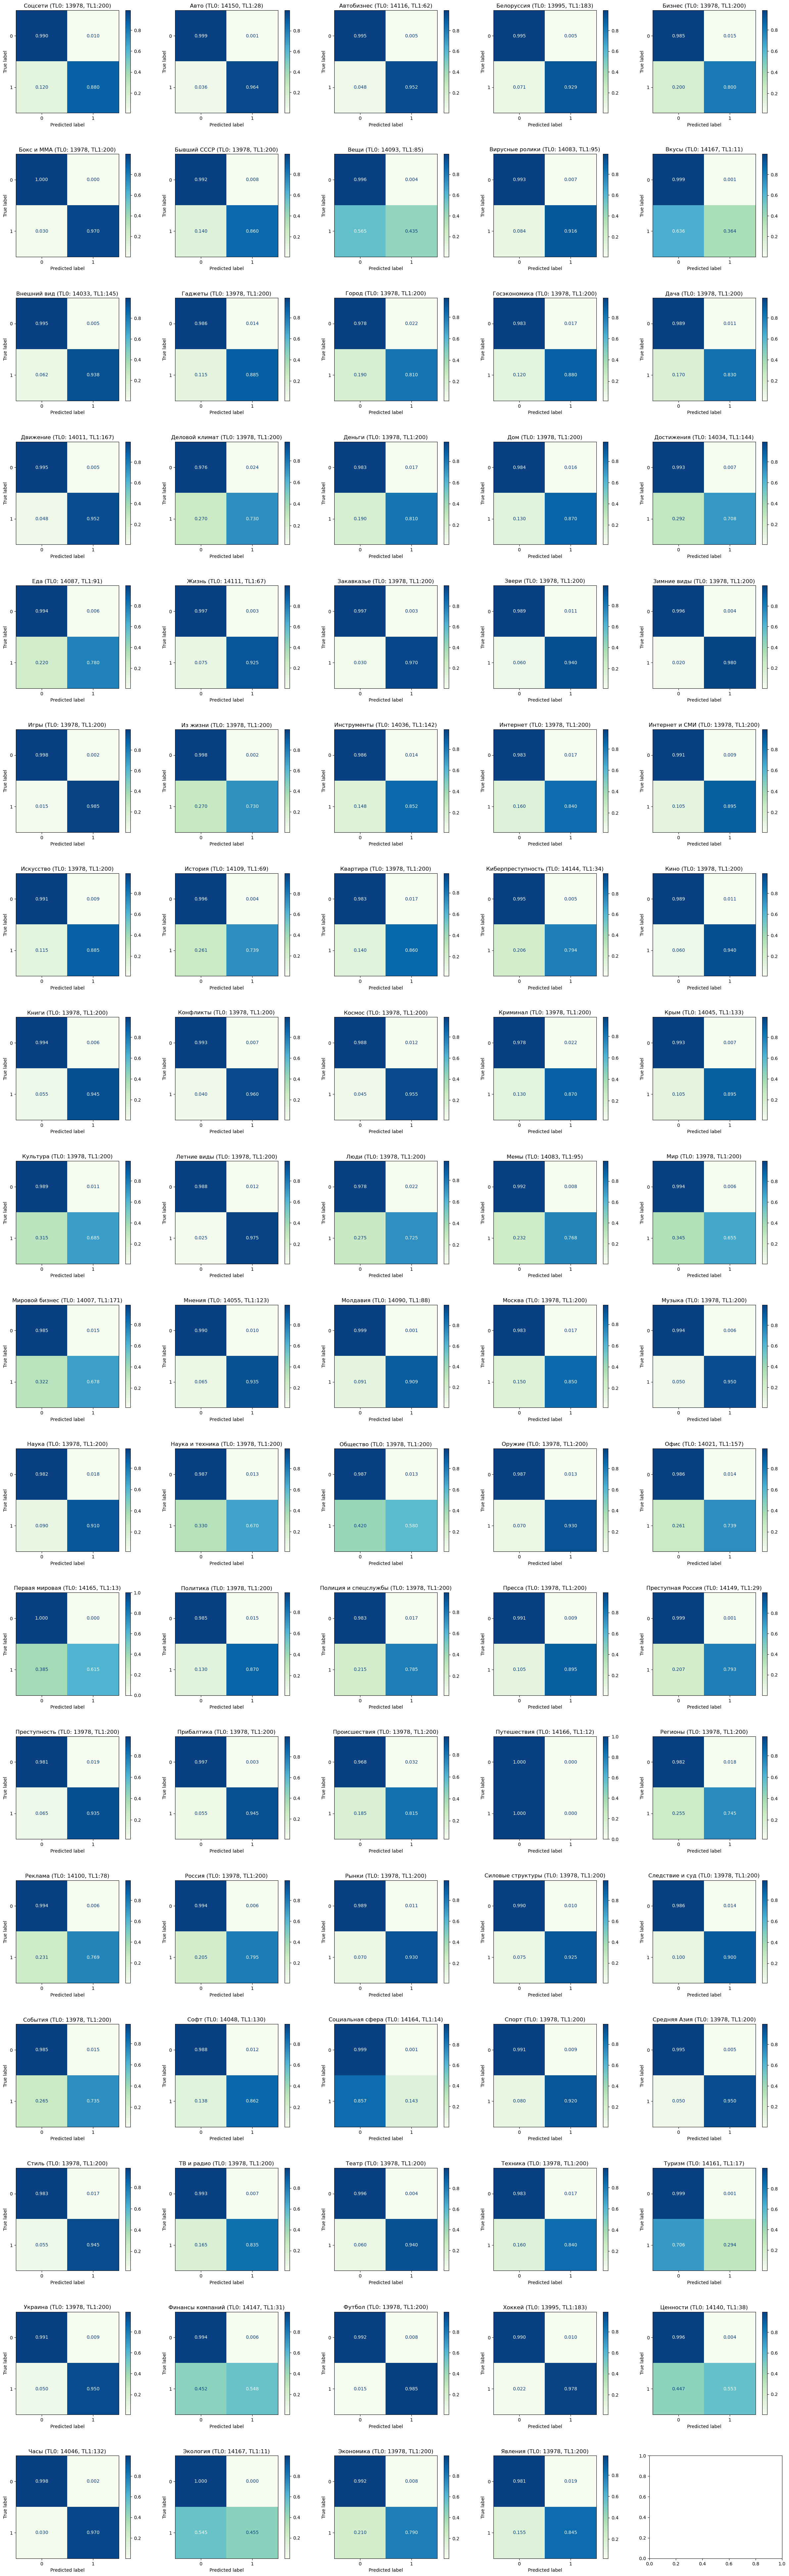

Время выполнения: 7.268 с


In [413]:
cm_show(y_test, 
        y_pred, 
        nrows=18, 
        ncols=5, 
        figsize_w=30, 
        figsize_h=100, 
        wspace=0.2, 
        hspace=0.4
        )